# Trying to get learning of angles working

Let's go back to basics, ignore the probabilistic stuff and just try to get a NN to learn the angles of MNIST digits. 

In [257]:
%load_ext autoreload
%autoreload 2

import os

os.environ["WANDB_NOTEBOOK_NAME"] = "selfsupervised.ipynb"
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true"

from typing import Optional, Union

from ml_collections import config_dict
import jax.random as random
import jax.numpy as jnp

jnp.log(jnp.exp(1) - 1.0)
# TODO: figure out why we get CUDA failures this ^ isn't here. 

import flax
from flax.training import train_state

import ciclo
import optax
import distrax

import jax
from jax import lax
import flax
import flax.linen as nn
flax.config.update('flax_use_orbax_checkpointing', True)

from clu import parameter_overview

from typing import Any

from functools import partial

import tensorflow_datasets as tfds

from clu import deterministic_data
from clu import preprocess_spec
from clu import metrics

from absl import logging
logging.set_verbosity(logging.INFO)

# set save plot face color to be white
import matplotlib.pyplot as plt
plt.rcParams["savefig.facecolor"] = "white"

from src.utils.preprocess import all_ops
from src.utils.training import setup_model, get_dataset_splits, train_loop
import src.utils.input as input_utils
from src.models.common import ResNet18
from src.transformations import transform_image


PRNGKey = Any

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [240]:
rng = random.PRNGKey(0)
train_data_rng, val_data_rng, init_rng, state_rng = random.split(rng, 4)

## Get data

In [241]:
ANGLE = 180

dataset_config = config_dict.ConfigDict()
dataset_config.batch_size = 512
dataset_config.dataset = "MNIST"
dataset_config.shuffle_buffer_size = 50_000
dataset_config.repeat_after_batching = True  # NOTE: ordering of PP, shuffle, and repeat is important!
dataset_config.train_split = f"train[10000:]"
dataset_config.pp_train = f'value_range(-1, 1)|random_rotate(-{ANGLE}, {ANGLE}, fill_value=-1)|keep(["image"])'
dataset_config.val_split = f"train[:10000]"
dataset_config.pp_eval = f'value_range(-1, 1)|random_rotate(-{ANGLE}, {ANGLE}, fill_value=-1)|keep(["image", "label"])'


In [242]:
# train_ds, val_ds, _ = get_dataset_splits(dataset_config, data_rng, dataset_config.batch_size, dataset_config.batch_size)

In [243]:
def get_data(dataset_config):
    dataset_builder = tfds.builder(dataset_config.dataset)
    dataset_builder.download_and_prepare()

    local_batch_size  = dataset_config.batch_size // jax.device_count()

    train_ds = deterministic_data.create_dataset(
        dataset_builder,
        split=tfds.split_for_jax_process(dataset_config.train_split),
        # This RNG key will be used to derive all randomness in shuffling, data
        # preprocessing etc.
        rng=train_data_rng,
        shuffle_buffer_size=dataset_config.shuffle_buffer_size,
        # Depending on TPU/other runtime, local device count will be 8/1.
        batch_dims=[jax.local_device_count(), local_batch_size],
        repeat_after_batching=False,
        preprocess_fn=preprocess_spec.parse(
            spec=dataset_config.pp_train,
            available_ops=all_ops(),
        ),
        shuffle="loaded",
        )


    num_val_examples = dataset_builder.info.splits[dataset_config.val_split].num_examples
    # Compute how many batches we need to contain the entire val set.
    pad_up_to_batches = int(jnp.ceil(num_val_examples / dataset_config.batch_size))

    val_ds = deterministic_data.create_dataset(
        dataset_builder,
        split=tfds.split_for_jax_process(dataset_config.val_split),
        rng=val_data_rng,
        batch_dims=[jax.local_device_count(), local_batch_size],
        num_epochs=1,
        preprocess_fn=preprocess_spec.parse(
            spec=dataset_config.pp_eval,
            available_ops=all_ops(),
        ),
        # Pad with masked examples instead of dropping incomplete final batch.
        pad_up_to_batches=pad_up_to_batches,
        shuffle=False)

    return train_ds, val_ds

## Setup TrainState and NN

In [244]:
@flax.struct.dataclass  # <-- required for JAX transformations
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output('loss')
    η_mse: metrics.Average.from_output('η_mse')
    x_mse: metrics.Average.from_output('x_mse')

    def update(self, **kwargs) -> "Metrics":
        updates = self.single_from_model_output(**kwargs)
        return self.merge(updates)

class TrainState(train_state.TrainState):
    metrics: Metrics
    rng: PRNGKey
    λ: float
    λ_schedule: optax.Schedule = flax.struct.field(pytree_node=False)
    polyak_step_size: Optional[float] = None
    avg_params: Optional[flax.core.FrozenDict] = None

    def apply_gradients(self, *, grads, **kwargs):
        updates, new_opt_state = self.tx.update(grads, self.opt_state, self.params)
        new_params = optax.apply_updates(self.params, updates)

        if self.polyak_step_size is not None:
            new_avg_params = optax.incremental_update(new_params, self.avg_params, self.polyak_step_size)
        else:
            new_avg_params = None

        return self.replace(
            step=self.step + 1,
            params=new_params,
            opt_state=new_opt_state,
            λ=self.λ_schedule(self.step),
            avg_params=new_avg_params,
            **kwargs,
        )

    @classmethod
    def create(
        cls,
        *,
        apply_fn,
        params,
        tx,
        λ_schedule,
        **kwargs,
    ):
        opt_state = tx.init(params)
        if kwargs.get("polyak_step_size", None) is not None:
            avg_params = params
        else:
            avg_params = None
        return cls(
            step=0,
            apply_fn=apply_fn,
            params=params,
            tx=tx,
            opt_state=opt_state,
            λ_schedule=λ_schedule,
            λ=λ_schedule(0),
            avg_params=avg_params,
            **kwargs,
        )

def reset_metrics(state):
    return state.replace(metrics=state.metrics.empty())

In [245]:
BOUNDS_ARRAY = jnp.array((0.25, 0.25, jnp.pi, 0.25, 0.25))

class MyModel(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool = True):


        # ResNet version
        # h = ResNet18(lowres=True, num_classes=64, num_filters=64)(x, train=train)


        # # CNN version
        h = x

        # for i, conv_dim in enumerate([64, 128, 256]):
        #     h = nn.Conv(
        #         conv_dim,
        #         kernel_size=(3, 3),
        #         strides=(2, 2) if i == 0 else (1, 1),
        #     )(h)
        #     h = nn.LayerNorm()(h)
        #     h = nn.relu(h)

        # ## Fully-conv version
        # h = nn.Conv(BOUNDS_ARRAY.shape[0], kernel_size=(3, 3), strides=(1, 1))(h)
        # features = jnp.mean(h, axis=(0, 1))
        
        # features = jax.nn.tanh(features)
        # return features * BOUNDS_ARRAY


        # ## Standard version 
        # h = nn.Conv(3, kernel_size=(3, 3), strides=(1, 1))(h)

        h = h.flatten()

        for dense_dim in [1024, 512, 256, 128]:
            h_ = h

            h = nn.Dense(dense_dim)(h)
            # h = nn.LayerNorm()(h)
            h = nn.relu(h)
            h = nn.Dropout(rate=0., deterministic=not train)(h)

            # if h_.shape == h.shape:
            #     h = h + h_


        # Regression version
        features = nn.Dense(
            BOUNDS_ARRAY.shape[0],
            # kernel_init=nn.initializers.zeros_init()
        )(h)

        features = jax.nn.tanh(features)
        return features * BOUNDS_ARRAY



## Supervised learning

In [9]:
train_ds, val_ds = get_data(dataset_config)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)


INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image']):
{'image': 'float32[28, 28, 1]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]'}
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[:10000]', index=0, count=1, dro

In [10]:
model = MyModel()

variables = model.init(init_rng, jnp.empty((28, 28, 2)), train=False)

parameter_overview.log_parameter_overview(variables)

INFO:absl:
+-----------------------+--------------+-----------+-----------+--------+
| Name                  | Shape        | Size      | Mean      | Std    |
+-----------------------+--------------+-----------+-----------+--------+
| params/Dense_0/bias   | (2048,)      | 2,048     | 0.0       | 0.0    |
| params/Dense_0/kernel | (1568, 2048) | 3,211,264 | -9.56e-06 | 0.0252 |
| params/Dense_1/bias   | (1024,)      | 1,024     | 0.0       | 0.0    |
| params/Dense_1/kernel | (2048, 1024) | 2,097,152 | 1.31e-05  | 0.0221 |
| params/Dense_2/bias   | (1024,)      | 1,024     | 0.0       | 0.0    |
| params/Dense_2/kernel | (1024, 1024) | 1,048,576 | -6.31e-06 | 0.0313 |
| params/Dense_3/bias   | (1024,)      | 1,024     | 0.0       | 0.0    |
| params/Dense_3/kernel | (1024, 1024) | 1,048,576 | 1.18e-05  | 0.0312 |
| params/Dense_4/bias   | (1024,)      | 1,024     | 0.0       | 0.0    |
| params/Dense_4/kernel | (1024, 1024) | 1,048,576 | 1.47e-05  | 0.0313 |
| params/Dense_5/bias   | (

In [11]:
TOTAL_STEPS = 5_000
LR = 1e-4

state = TrainState.create(
    apply_fn=model.apply,
    params=variables["params"],
    tx=optax.inject_hyperparams(optax.adamw)(LR),
    metrics=Metrics.empty(),
    rng=state_rng,
    λ_schedule=optax.cosine_decay_schedule(1, TOTAL_STEPS, 1)
)

In [12]:
def loss_fn(x, params, state, step_rng, train):
    rng_local = random.fold_in(step_rng, lax.axis_index("batch"))
    rng_dropout, rng_η = random.split(rng_local)

    Η_rand = distrax.Uniform(low=-BOUNDS_ARRAY, high=BOUNDS_ARRAY)
    η_rand = Η_rand.sample(seed=rng_η, sample_shape=())
    x_rand = transform_image(x, η_rand)

    mask = distrax.Bernoulli(probs=state.λ).sample(seed=rng_dropout)

    η_x_rand = state.apply_fn(
        {"params": params},
        jnp.concatenate([x_rand, (x_rand - x)*mask], axis=-1),
        train, rngs={"dropout": rng_dropout}
    )

    η_mse = optax.squared_error(η_rand - η_x_rand).mean()
    x_mse = optax.squared_error(x, transform_image(x, η_rand - η_x_rand)).mean()

    loss = η_mse

    return loss, {"loss": loss, "η_mse": η_mse, "x_mse": x_mse}


@jax.jit
def train_step(state, batch):
    step_rng = random.fold_in(state.rng, state.step)

    def batch_loss_fn(params):
        losses, metrics = jax.vmap(loss_fn, in_axes=(0, None, None, None, None), axis_name="batch")(
            batch["image"][0], params, state, step_rng, True
        )

        avg_loss = losses.mean(axis=0)

        return avg_loss, metrics

    (_, metrics), grads = jax.value_and_grad(batch_loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)

    metrics = state.metrics.update(
        **metrics
    )
    logs = ciclo.logs()
    logs.add_stateful_metrics(**metrics.compute())
    logs.add_entry("schedules", "λ", state.λ)
    logs.add_entry("schedules", "lr", state.opt_state.hyperparams["learning_rate"])

    return logs, state.replace(metrics=metrics)


@jax.jit
def eval_step(state, batch):
    step_rng = random.fold_in(state.rng, state.step)

    masks = batch["mask"][0]

    def batch_loss_fn(params):
        losses, metrics = jax.vmap(loss_fn, in_axes=(0, None, None, None, None), axis_name="batch")(
            batch["image"][0], params, state, step_rng, False
        )

        avg_loss = (losses * masks).sum(axis=0) / masks.sum(axis=0)

        return avg_loss, metrics

    # _, metrics = batch_loss_fn(state.params)
    _, metrics = batch_loss_fn(state.avg_params if state.avg_params is not None else state.params)

    metrics = state.metrics.update(
        **metrics, mask=masks
    )
    logs = ciclo.logs()
    logs.add_stateful_metrics(**metrics.compute())

    return logs, state.replace(metrics=metrics)

In [13]:
state, history, _ = ciclo.train_loop(
    state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: eval_step,
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=TOTAL_STEPS // 100,
    callbacks=[
        ciclo.keras_bar(total=TOTAL_STEPS),
    ],
    stop=TOTAL_STEPS + 1,
)

5000/5000 [==============================] - 84s 17ms/step - loss: 0.1166 - x_mse: 0.2517 - η_mse: 0.1166 - loss_test: 0.1063 - x_mse_test: 0.2509 - η_mse_test: 0.1063


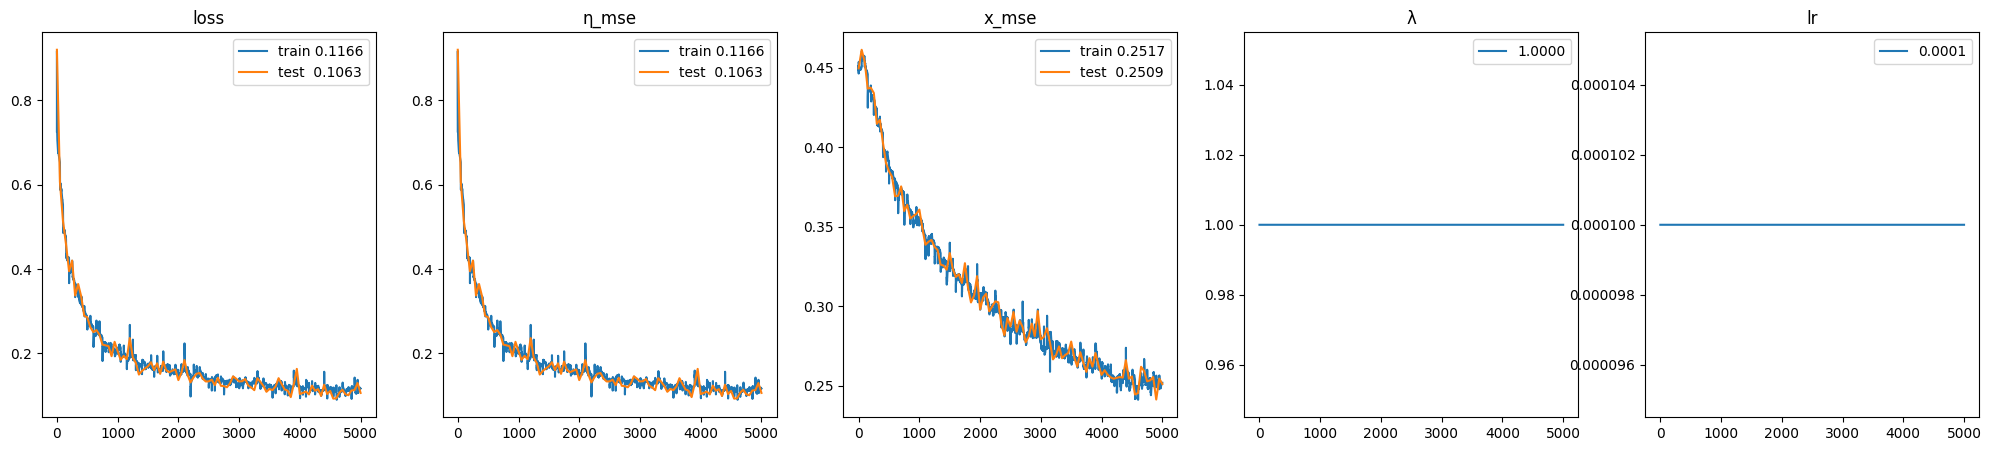

In [14]:
# plot the training history
steps, loss, η_mse, x_mse, λ, lr = history.collect(
    "steps", "loss", "η_mse", "x_mse", "λ", "lr"
)
steps_test, loss_test, η_mse_test, x_mse_test = history.collect(
    "steps", "loss_test", "η_mse_test", "x_mse_test"
)

n_plots = 5
fig, axs = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))

axs[0].plot(steps, loss, label=f"train {loss[-1]:.4f}")
axs[0].plot(steps_test, loss_test, label=f"test  {loss_test[-1]:.4f}")
axs[0].legend()
axs[0].set_title("loss")

axs[1].plot(steps, η_mse, label=f"train {η_mse[-1]:.4f}")
axs[1].plot(steps_test, η_mse_test, label=f"test  {η_mse_test[-1]:.4f}")
axs[1].legend()
axs[1].set_title("η_mse")

axs[2].plot(steps, x_mse, label=f"train {x_mse[-1]:.4f}")
axs[2].plot(steps_test, x_mse_test, label=f"test  {x_mse_test[-1]:.4f}")
axs[2].legend()
axs[2].set_title("x_mse")

axs[3].plot(steps, λ, label=f"{λ[-1]:.4f}")
axs[3].legend()
axs[3].set_title("λ")

axs[4].plot(steps, lr, label=f"{lr[-1]:.4f}")
axs[4].legend()
axs[4].set_title("lr")

plt.show()

## Self-supervised

In [272]:
train_ds, val_ds = get_data(dataset_config)

INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/homes/jua23/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}


INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image']):
{'image': 'float32[28, 28, 1]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]'}
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[:10000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=-3.141592653589793, θ_max=3.141592653589793, fill_mode='nearest

In [273]:
ss_model = MyModel()

ss_variables = ss_model.init(init_rng, jnp.empty((28, 28, 1)), train=False)

# parameter_overview.log_parameter_overview(ss_variables)

def update_params(ss_params, state_params):
    for key in ss_params.keys():
        if "Dense_5" in key:
            continue
        if isinstance(ss_params[key], dict) and isinstance(state_params[key], dict):
            update_params(ss_params[key], state_params[key])
        elif ss_params[key].shape == state_params[key].shape:
            ss_params[key] = state_params[key]

# update_params(ss_variables["params"], state.params)

parameter_overview.log_parameter_overview(ss_variables)

INFO:absl:
+-----------------------+-------------+---------+-----------+--------+
| Name                  | Shape       | Size    | Mean      | Std    |
+-----------------------+-------------+---------+-----------+--------+
| params/Dense_0/bias   | (1024,)     | 1,024   | 0.0       | 0.0    |
| params/Dense_0/kernel | (784, 1024) | 802,816 | 1.15e-05  | 0.0357 |
| params/Dense_1/bias   | (512,)      | 512     | 0.0       | 0.0    |
| params/Dense_1/kernel | (1024, 512) | 524,288 | -0.000119 | 0.0313 |
| params/Dense_2/bias   | (256,)      | 256     | 0.0       | 0.0    |
| params/Dense_2/kernel | (512, 256)  | 131,072 | 0.00012   | 0.0442 |
| params/Dense_3/bias   | (128,)      | 128     | 0.0       | 0.0    |
| params/Dense_3/kernel | (256, 128)  | 32,768  | 0.000224  | 0.0624 |
| params/Dense_4/bias   | (5,)        | 5       | 0.0       | 0.0    |
| params/Dense_4/kernel | (128, 5)    | 640     | 0.00888   | 0.09   |
+-----------------------+-------------+---------+-----------+-----

In [ ]:
# def map_nested_fn(fn):
#   '''Recursively apply `fn` to the key-value pairs of a nested dict'''
#   def map_fn(nested_dict):
#     return {k: (map_fn(v) if isinstance(v, dict) else fn(k, v))
#             for k, v in nested_dict.items()}
#   return map_fn

# params = {'linear_1': {'w': jnp.zeros((5, 6)), 'b': jnp.zeros(5)},
#           'linear_2': {'w': jnp.zeros((6, 1)), 'b': jnp.zeros(1)}}
# gradients = jax.tree_util.tree_map(jnp.ones_like, params)  # dummy gradients

# label_fn = map_nested_fn(lambda k, _: k)
# tx = optax.multi_transform({'w': optax.adam(1.0), 'b': optax.sgd(1.0)},
#                            label_fn)
# state = tx.init(params)
# updates, new_state = tx.update(gradients, state, params)
# new_params = optax.apply_updates(params, updates)

In [275]:
TOTAL_STEPS = 10_000
LR = 1e-4
N_SAMPLES = 5
POLYAK_STEP_SIZE = None

from flax import traverse_util

def lr_schedule(init_lr, peak_mult, final_mult, peak_steps): 
    return optax.warmup_cosine_decay_schedule(
        init_lr, init_lr*peak_mult, peak_steps, TOTAL_STEPS, end_value=init_lr*final_mult
    )

# partition_optimizers = {
#     'fast': optax.inject_hyperparams(optax.adamw)(lr_schedule(1e-4, 3, 1/1000, TOTAL_STEPS//10)),
#     'slow': optax.inject_hyperparams(optax.adamw)(lr_schedule(1e-6, 100, 1/10, TOTAL_STEPS//3)),
# }
# param_partitions = flax.core.freeze(traverse_util.path_aware_map(
#   lambda path, v: 'fast' if ('Dense_5' in path or 'Dense_0' in path) else 'slow', ss_variables["params"]))
# tx = optax.multi_transform(partition_optimizers, lambda dict: {k: 'fast' if ('Dense_5' in k or 'Dense_0' in k) else 'slow' for k in dict.keys()})

def clipped_adamw(learning_rate, norm):
    return optax.MultiSteps(optax.chain(
        optax.clip_by_global_norm(norm),
        optax.adamw(learning_rate=learning_rate)
    ), 1)

ss_state = TrainState.create(
    apply_fn=ss_model.apply,
    params=ss_variables["params"],
    # tx=optax.inject_hyperparams(optax.adamw)(lr_schedule(LR, 3, 1/1000, TOTAL_STEPS//10)),
    # tx=optax.inject_hyperparams(clipped_adamw)(lr_schedule(LR, 3, 1/100, TOTAL_STEPS//10), 2.),
    tx=optax.inject_hyperparams(clipped_adamw)(lr_schedule(LR, 3, 1/30, TOTAL_STEPS//10), 2.),  # best
    # tx=optax.inject_hyperparams(clipped_adamw)(lr_schedule(LR, 10, 1/300, TOTAL_STEPS//10), 2.),  # better for longer training runs
    # tx=tx,
    metrics=Metrics.empty(),
    rng=state_rng,
    λ_schedule=optax.cosine_decay_schedule(1, TOTAL_STEPS, 1),
    polyak_step_size=POLYAK_STEP_SIZE,
)

In [276]:
def loss_fn(
    x, params, state, step_rng, train, n_samples, τ
):
    """Self-supervised loss function. 
    
    The loss can be summarised with the following diagram

            x ------- -η_x -----> x_hat
            |                       |
            |                       v
         η_rand                    mse
            |                       ∧
            ∨                       |
         x_rand --- -η_x_rand ---> x_hat'.

    However, implementing this directly requires doing 3 affine transformations, which adds 'blur' to the image.
    So instead we note that the diagram above is equivalent to

            x --------> mse <------- x'
            |                        ∧
            |                        |
         η_rand                     η_x
            |                        |
            v                        |
         x_rand --- -η_x_rand ---> x_hat'.

    Finally, this computation can be simplified to

            x --------> mse <-------- x'
            |                         ∧
            └ η_rand - η_x_rand + η_x ┘

    which contains only a single transformation.

    """
    rng_local = random.fold_in(step_rng, lax.axis_index("batch"))
    rng_dropout, rng_η = random.split(rng_local)

    def per_sample_loss(rng):
        η_x = state.apply_fn({"params": params}, x, train, rngs={"dropout": rng_dropout})

        Η_rand = distrax.Uniform(
            low=-BOUNDS_ARRAY * state.λ,
            high=BOUNDS_ARRAY * state.λ
        )
        η_rand = Η_rand.sample(seed=rng, sample_shape=())

        # def weighted_uniform_sample(rng):
        #     rng_1, rng_2 = random.split(rng)

        #     mask = jnp.array([True, True, False, True, True])

        #     def _weight_fn(samples):
        #         # Compute the distance of each sample from the extreme values
        #         distance = jnp.minimum(jnp.abs(samples - BOUNDS_ARRAY), jnp.abs(samples + BOUNDS_ARRAY))
        #         # Compute the weights based on the distance
        #         # weights = jnp.prod((1 - distance / BOUNDS_ARRAY)[:,mask], axis=-1)
        #         weights = jnp.where(mask, 1 - distance / BOUNDS_ARRAY, 1).prod(axis=-1)
        #         return weights

        #     # Generate a fixed number of uniform samples
        #     samples = Η_rand.sample(seed=rng_1, sample_shape=(1000,))
        #     # Compute the weights based on the distance from the extreme values
        #     weights = _weight_fn(samples)
        #     # Apply the temperature to the weights
        #     weights = jnp.power(weights, 1.0 / τ)
        #     # Normalize the weights
        #     weights /= jnp.sum(weights)
        #     # Resample the samples with the computed weights
        #     resampled_samples = distrax.Categorical(probs=weights).sample(seed=rng_2, sample_shape=())
        #     return jnp.take(samples, resampled_samples, axis=0)

        # η_rand = weighted_uniform_sample(rng)

        x_rand = transform_image(x, η_rand)
        η_x_rand = state.apply_fn({"params": params}, x_rand, train, rngs={"dropout": rng_dropout})

        x_mse = optax.squared_error(x, transform_image(x, η_rand - η_x_rand + η_x)).mean()
        η_mse = optax.squared_error(η_rand - η_x_rand + η_x).mean()

        loss = x_mse

        difficulty = optax.squared_error(x, x_rand).mean()

        return loss, x_mse, η_mse, difficulty
    
    rngs = random.split(rng_η, n_samples)
    loss, x_mse, η_mse, difficulty = jax.vmap(per_sample_loss)(rngs)
    
    # do a weighted average based on the difficulty of the sample
    # weights = jax.nn.softmax(difficulty)
    weights = difficulty / difficulty.sum()
    loss, x_mse, η_mse = jax.tree_map(lambda x: (x * weights).sum(axis=0), (loss, x_mse, η_mse))

    # loss, x_mse, η_mse = jax.tree_map(lambda x: x.mean(axis=0), (loss, x_mse, η_mse))

    return loss, {"loss": loss, "η_mse": η_mse, "x_mse": x_mse}


@jax.jit
def train_step(state, batch):
    step_rng = random.fold_in(state.rng, state.step)

    def batch_loss_fn(params):
        losses, metrics = jax.vmap(loss_fn, in_axes=(0, None, None, None, None, None, None), axis_name="batch")(
            batch["image"][0], params, state, step_rng, True, N_SAMPLES, 2.
        )

        avg_loss = losses.mean(axis=0)

        return avg_loss, metrics

    (_, metrics), grads = jax.value_and_grad(batch_loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)

    metrics = state.metrics.update(
        **metrics
    )
    logs = ciclo.logs()
    logs.add_stateful_metrics(**metrics.compute())
    logs.add_entry("schedules", "λ", state.λ)
    logs.add_entry("schedules", "lr", state.opt_state.hyperparams["learning_rate"])
    # logs.add_entry("schedules", "lr_fast", state.opt_state.inner_states['fast'][0].hyperparams["learning_rate"])
    # logs.add_entry("schedules", "lr_slow", state.opt_state.inner_states['slow'][0].hyperparams["learning_rate"])
    logs.add_entry("gradients", "grad_norm", optax.global_norm(grads))

    return logs, state.replace(metrics=metrics)


@jax.jit
def eval_step(state, batch):
    step_rng = random.fold_in(state.rng, state.step)

    masks = batch["mask"][0]

    def batch_loss_fn(params):
        losses, metrics = jax.vmap(loss_fn, in_axes=(0, None, None, None, None, None, None), axis_name="batch")(
            batch["image"][0], params, state, step_rng, False, 1, jnp.inf
        )

        avg_loss = (losses * masks).sum(axis=0) / masks.sum(axis=0)

        return avg_loss, metrics

    # _, metrics = batch_loss_fn(state.params)
    _, metrics = batch_loss_fn(state.params if state.avg_params is None else state.avg_params)

    metrics = state.metrics.update(
        **metrics, mask=masks
    )
    logs = ciclo.logs()
    logs.add_stateful_metrics(**metrics.compute())

    return logs, state.replace(metrics=metrics)

In [277]:
ss_state, ss_history, _ = ciclo.train_loop(
    ss_state,
    deterministic_data.start_input_pipeline(train_ds),
    {
        ciclo.on_train_step: [
            train_step
        ],
        ciclo.on_reset_step: reset_metrics,
        ciclo.on_test_step: eval_step,
    },
    test_dataset=lambda: deterministic_data.start_input_pipeline(val_ds),
    epoch_duration=TOTAL_STEPS // 100,
    callbacks=[
        ciclo.keras_bar(total=TOTAL_STEPS),
        # ciclo.early_stopping("loss_test", patience=TOTAL_STEPS // 10, min_delta=1e-4, mode="min", restore_best_weights=True),
        ciclo.checkpoint("ss_model", monitor="loss_test", mode="min", overwrite=True),
    ],
    stop=TOTAL_STEPS + 1,
)

INFO:absl:Saving checkpoint at step: -0.44910115
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.44910115003585815.
INFO:absl:Renaming ss_model/checkpoint_-0.44910115003585815.orbax-checkpoint-tmp-1693321425215108 to ss_model/checkpoint_-0.44910115003585815
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.44910115003585815`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.19912563264369965


   99/10000 [..............................] - ETA: 15:13 - loss: 0.3727 - x_mse: 0.3727 - η_mse: 0.8488 - loss_test: 0.4491 - x_mse_test: 0.4491 - η_mse_test: 0.6950

INFO:absl:Saving checkpoint at step: -0.3363753
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.33637529611587524.
INFO:absl:Renaming ss_model/checkpoint_-0.33637529611587524.orbax-checkpoint-tmp-1693321427161115 to ss_model/checkpoint_-0.33637529611587524
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.33637529611587524`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.44910115003585815


  198/10000 [..............................] - ETA: 9:09 - loss: 0.3252 - x_mse: 0.3252 - η_mse: 0.9006 - loss_test: 0.3364 - x_mse_test: 0.3364 - η_mse_test: 0.8973

INFO:absl:Saving checkpoint at step: -0.31465822
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.3146582245826721.
INFO:absl:Renaming ss_model/checkpoint_-0.3146582245826721.orbax-checkpoint-tmp-1693321429094840 to ss_model/checkpoint_-0.3146582245826721
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.3146582245826721`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.33637529611587524


  296/10000 [..............................] - ETA: 7:06 - loss: 0.3092 - x_mse: 0.3092 - η_mse: 0.9312 - loss_test: 0.3147 - x_mse_test: 0.3147 - η_mse_test: 0.9477

INFO:absl:Saving checkpoint at step: -0.30126426
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.3012642562389374.
INFO:absl:Renaming ss_model/checkpoint_-0.3012642562389374.orbax-checkpoint-tmp-1693321431040214 to ss_model/checkpoint_-0.3012642562389374
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.3012642562389374`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.3146582245826721


  496/10000 [>.............................] - ETA: 5:16 - loss: 0.2960 - x_mse: 0.2960 - η_mse: 0.9532 - loss_test: 0.3022 - x_mse_test: 0.3022 - η_mse_test: 0.9836

INFO:absl:Saving checkpoint at step: -0.2891923
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.2891922891139984.
INFO:absl:Renaming ss_model/checkpoint_-0.2891922891139984.orbax-checkpoint-tmp-1693321434521051 to ss_model/checkpoint_-0.2891922891139984
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.2891922891139984`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.3012642562389374


  599/10000 [>.............................] - ETA: 4:48 - loss: 0.2915 - x_mse: 0.2915 - η_mse: 0.9556 - loss_test: 0.2892 - x_mse_test: 0.2892 - η_mse_test: 0.9511

INFO:absl:Saving checkpoint at step: -0.27906454
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.2790645360946655.
INFO:absl:Renaming ss_model/checkpoint_-0.2790645360946655.orbax-checkpoint-tmp-1693321436343096 to ss_model/checkpoint_-0.2790645360946655
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.2790645360946655`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.2891922891139984


 1196/10000 [==>...........................] - ETA: 3:32 - loss: 0.2828 - x_mse: 0.2828 - η_mse: 0.9805 - loss_test: 0.2793 - x_mse_test: 0.2793 - η_mse_test: 0.9690

INFO:absl:Saving checkpoint at step: -0.27710605
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.27710604667663574.
INFO:absl:Renaming ss_model/checkpoint_-0.27710604667663574.orbax-checkpoint-tmp-1693321446877049 to ss_model/checkpoint_-0.27710604667663574
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.27710604667663574`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.2790645360946655


 1296/10000 [==>...........................] - ETA: 3:26 - loss: 0.2793 - x_mse: 0.2793 - η_mse: 0.9815 - loss_test: 0.2771 - x_mse_test: 0.2771 - η_mse_test: 0.9913

INFO:absl:Saving checkpoint at step: -0.26939884
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.26939883828163147.
INFO:absl:Renaming ss_model/checkpoint_-0.26939883828163147.orbax-checkpoint-tmp-1693321448834831 to ss_model/checkpoint_-0.26939883828163147
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.26939883828163147`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.27710604667663574


 1496/10000 [===>..........................] - ETA: 3:15 - loss: 0.2767 - x_mse: 0.2767 - η_mse: 0.9936 - loss_test: 0.2755 - x_mse_test: 0.2755 - η_mse_test: 0.9641

INFO:absl:Saving checkpoint at step: -0.26935378
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.2693537771701813.
INFO:absl:Renaming ss_model/checkpoint_-0.2693537771701813.orbax-checkpoint-tmp-1693321452362349 to ss_model/checkpoint_-0.2693537771701813
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.2693537771701813`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.26939883828163147


 1896/10000 [====>.........................] - ETA: 2:56 - loss: 0.2741 - x_mse: 0.2741 - η_mse: 1.0082 - loss_test: 0.2719 - x_mse_test: 0.2719 - η_mse_test: 1.0190

INFO:absl:Saving checkpoint at step: -0.2682884
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.26828840374946594.
INFO:absl:Renaming ss_model/checkpoint_-0.26828840374946594.orbax-checkpoint-tmp-1693321459244130 to ss_model/checkpoint_-0.26828840374946594
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.26828840374946594`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.2693537771701813


 2499/10000 [======>.......................] - ETA: 2:36 - loss: 0.2693 - x_mse: 0.2693 - η_mse: 1.1671 - loss_test: 0.2699 - x_mse_test: 0.2699 - η_mse_test: 1.1597

INFO:absl:Saving checkpoint at step: -0.26645446
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.26645445823669434.
INFO:absl:Renaming ss_model/checkpoint_-0.26645445823669434.orbax-checkpoint-tmp-1693321470098933 to ss_model/checkpoint_-0.26645445823669434
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.26645445823669434`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.26828840374946594


 2598/10000 [======>.......................] - ETA: 2:34 - loss: 0.2692 - x_mse: 0.2692 - η_mse: 1.1569 - loss_test: 0.2665 - x_mse_test: 0.2665 - η_mse_test: 1.2715

INFO:absl:Saving checkpoint at step: -0.26057464
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.2605746388435364.
INFO:absl:Renaming ss_model/checkpoint_-0.2605746388435364.orbax-checkpoint-tmp-1693321472115778 to ss_model/checkpoint_-0.2605746388435364
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.2605746388435364`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.26645445823669434


 2799/10000 [=======>......................] - ETA: 2:28 - loss: 0.2641 - x_mse: 0.2641 - η_mse: 1.4463 - loss_test: 0.2651 - x_mse_test: 0.2651 - η_mse_test: 1.3991

INFO:absl:Saving checkpoint at step: -0.25992766
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.2599276602268219.
INFO:absl:Renaming ss_model/checkpoint_-0.2599276602268219.orbax-checkpoint-tmp-1693321475702353 to ss_model/checkpoint_-0.2599276602268219
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.2599276602268219`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.2605746388435364


 2899/10000 [=======>......................] - ETA: 2:25 - loss: 0.2546 - x_mse: 0.2546 - η_mse: 1.5137 - loss_test: 0.2599 - x_mse_test: 0.2599 - η_mse_test: 1.4591

INFO:absl:Saving checkpoint at step: -0.2523664
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.25236639380455017.
INFO:absl:Renaming ss_model/checkpoint_-0.25236639380455017.orbax-checkpoint-tmp-1693321477542447 to ss_model/checkpoint_-0.25236639380455017
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.25236639380455017`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.2599276602268219


 2999/10000 [=======>......................] - ETA: 2:23 - loss: 0.2521 - x_mse: 0.2521 - η_mse: 1.5895 - loss_test: 0.2524 - x_mse_test: 0.2524 - η_mse_test: 1.5202

INFO:absl:Saving checkpoint at step: -0.24895531
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.24895530939102173.
INFO:absl:Renaming ss_model/checkpoint_-0.24895530939102173.orbax-checkpoint-tmp-1693321479373089 to ss_model/checkpoint_-0.24895530939102173
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.24895530939102173`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.25236639380455017


 3196/10000 [========>.....................] - ETA: 2:18 - loss: 0.2486 - x_mse: 0.2486 - η_mse: 1.5862 - loss_test: 0.2543 - x_mse_test: 0.2543 - η_mse_test: 1.7578

INFO:absl:Saving checkpoint at step: -0.2437924
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.24379239976406097.
INFO:absl:Renaming ss_model/checkpoint_-0.24379239976406097.orbax-checkpoint-tmp-1693321483015750 to ss_model/checkpoint_-0.24379239976406097
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.24379239976406097`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.24895530939102173


 3299/10000 [========>.....................] - ETA: 2:15 - loss: 0.2450 - x_mse: 0.2450 - η_mse: 1.5979 - loss_test: 0.2438 - x_mse_test: 0.2438 - η_mse_test: 1.4075

INFO:absl:Saving checkpoint at step: -0.24104044
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.24104043841362.
INFO:absl:Renaming ss_model/checkpoint_-0.24104043841362.orbax-checkpoint-tmp-1693321484902154 to ss_model/checkpoint_-0.24104043841362
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.24104043841362`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.24379239976406097


 3396/10000 [=========>....................] - ETA: 2:13 - loss: 0.2387 - x_mse: 0.2387 - η_mse: 1.7464 - loss_test: 0.2410 - x_mse_test: 0.2410 - η_mse_test: 1.7021

INFO:absl:Saving checkpoint at step: -0.23916304
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.23916304111480713.
INFO:absl:Renaming ss_model/checkpoint_-0.23916304111480713.orbax-checkpoint-tmp-1693321486766028 to ss_model/checkpoint_-0.23916304111480713
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.23916304111480713`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.24104043841362


 3499/10000 [=========>....................] - ETA: 2:11 - loss: 0.2376 - x_mse: 0.2376 - η_mse: 1.7802 - loss_test: 0.2392 - x_mse_test: 0.2392 - η_mse_test: 1.7573

INFO:absl:Saving checkpoint at step: -0.23813538
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.23813538253307343.
INFO:absl:Renaming ss_model/checkpoint_-0.23813538253307343.orbax-checkpoint-tmp-1693321488588403 to ss_model/checkpoint_-0.23813538253307343
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.23813538253307343`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.23916304111480713


 3599/10000 [=========>....................] - ETA: 2:08 - loss: 0.2378 - x_mse: 0.2378 - η_mse: 1.7647 - loss_test: 0.2381 - x_mse_test: 0.2381 - η_mse_test: 1.6338

INFO:absl:Saving checkpoint at step: -0.23095582
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.2309558242559433.
INFO:absl:Renaming ss_model/checkpoint_-0.2309558242559433.orbax-checkpoint-tmp-1693321490453840 to ss_model/checkpoint_-0.2309558242559433
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.2309558242559433`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.23813538253307343


 3896/10000 [==========>...................] - ETA: 2:01 - loss: 0.2336 - x_mse: 0.2336 - η_mse: 1.8974 - loss_test: 0.2373 - x_mse_test: 0.2373 - η_mse_test: 2.0809

INFO:absl:Saving checkpoint at step: -0.22912474
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.2291247397661209.
INFO:absl:Renaming ss_model/checkpoint_-0.2291247397661209.orbax-checkpoint-tmp-1693321495608566 to ss_model/checkpoint_-0.2291247397661209
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.2291247397661209`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.2309558242559433


 4199/10000 [===========>..................] - ETA: 1:54 - loss: 0.2289 - x_mse: 0.2289 - η_mse: 1.8323 - loss_test: 0.2354 - x_mse_test: 0.2354 - η_mse_test: 1.7061

INFO:absl:Saving checkpoint at step: -0.22854869
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.22854869067668915.
INFO:absl:Renaming ss_model/checkpoint_-0.22854869067668915.orbax-checkpoint-tmp-1693321501029666 to ss_model/checkpoint_-0.22854869067668915
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.22854869067668915`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.2291247397661209


 4299/10000 [===========>..................] - ETA: 1:52 - loss: 0.2286 - x_mse: 0.2286 - η_mse: 1.9446 - loss_test: 0.2285 - x_mse_test: 0.2285 - η_mse_test: 2.0549

INFO:absl:Saving checkpoint at step: -0.2275055
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.22750550508499146.
INFO:absl:Renaming ss_model/checkpoint_-0.22750550508499146.orbax-checkpoint-tmp-1693321503036639 to ss_model/checkpoint_-0.22750550508499146
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.22750550508499146`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.22854869067668915


 4496/10000 [============>.................] - ETA: 1:48 - loss: 0.2240 - x_mse: 0.2240 - η_mse: 1.8757 - loss_test: 0.2284 - x_mse_test: 0.2284 - η_mse_test: 1.9230

INFO:absl:Saving checkpoint at step: -0.22507675
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.22507674992084503.
INFO:absl:Renaming ss_model/checkpoint_-0.22507674992084503.orbax-checkpoint-tmp-1693321506681133 to ss_model/checkpoint_-0.22507674992084503
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.22507674992084503`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.22750550508499146


 4597/10000 [============>.................] - ETA: 1:46 - loss: 0.2240 - x_mse: 0.2240 - η_mse: 1.9530 - loss_test: 0.2251 - x_mse_test: 0.2251 - η_mse_test: 1.7967

INFO:absl:Saving checkpoint at step: -0.22400643
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.22400642931461334.
INFO:absl:Renaming ss_model/checkpoint_-0.22400642931461334.orbax-checkpoint-tmp-1693321508650946 to ss_model/checkpoint_-0.22400642931461334
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.22400642931461334`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.22507674992084503


 4699/10000 [=============>................] - ETA: 1:44 - loss: 0.2240 - x_mse: 0.2240 - η_mse: 1.9635 - loss_test: 0.2240 - x_mse_test: 0.2240 - η_mse_test: 1.8846

INFO:absl:Saving checkpoint at step: -0.22041081
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.2204108089208603.
INFO:absl:Renaming ss_model/checkpoint_-0.2204108089208603.orbax-checkpoint-tmp-1693321510469092 to ss_model/checkpoint_-0.2204108089208603
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.2204108089208603`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.22400642931461334


 5096/10000 [==============>...............] - ETA: 1:35 - loss: 0.2234 - x_mse: 0.2234 - η_mse: 1.9413 - loss_test: 0.2325 - x_mse_test: 0.2325 - η_mse_test: 1.9252

INFO:absl:Saving checkpoint at step: -0.2182745
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.21827450394630432.
INFO:absl:Renaming ss_model/checkpoint_-0.21827450394630432.orbax-checkpoint-tmp-1693321517355009 to ss_model/checkpoint_-0.21827450394630432
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.21827450394630432`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.2204108089208603


 5396/10000 [===============>..............] - ETA: 1:29 - loss: 0.2175 - x_mse: 0.2175 - η_mse: 1.9082 - loss_test: 0.2206 - x_mse_test: 0.2206 - η_mse_test: 1.9546

INFO:absl:Saving checkpoint at step: -0.2171176
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.21711759269237518.
INFO:absl:Renaming ss_model/checkpoint_-0.21711759269237518.orbax-checkpoint-tmp-1693321522823229 to ss_model/checkpoint_-0.21711759269237518
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.21711759269237518`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.21827450394630432


 5498/10000 [===============>..............] - ETA: 1:27 - loss: 0.2152 - x_mse: 0.2152 - η_mse: 1.9406 - loss_test: 0.2171 - x_mse_test: 0.2171 - η_mse_test: 1.7546

INFO:absl:Saving checkpoint at step: -0.20957789
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.20957788825035095.
INFO:absl:Renaming ss_model/checkpoint_-0.20957788825035095.orbax-checkpoint-tmp-1693321524874909 to ss_model/checkpoint_-0.20957788825035095
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.20957788825035095`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.21711759269237518


 6196/10000 [=================>............] - ETA: 1:13 - loss: 0.2135 - x_mse: 0.2135 - η_mse: 2.0665 - loss_test: 0.2120 - x_mse_test: 0.2120 - η_mse_test: 2.0736

INFO:absl:Saving checkpoint at step: -0.20675333
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.20675332844257355.
INFO:absl:Renaming ss_model/checkpoint_-0.20675332844257355.orbax-checkpoint-tmp-1693321537531821 to ss_model/checkpoint_-0.20675332844257355
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.20675332844257355`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.20957788825035095


 6396/10000 [==================>...........] - ETA: 1:09 - loss: 0.2106 - x_mse: 0.2106 - η_mse: 2.0481 - loss_test: 0.2071 - x_mse_test: 0.2071 - η_mse_test: 2.0199

INFO:absl:Saving checkpoint at step: -0.20666304
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.20666304230690002.
INFO:absl:Renaming ss_model/checkpoint_-0.20666304230690002.orbax-checkpoint-tmp-1693321541036868 to ss_model/checkpoint_-0.20666304230690002
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.20666304230690002`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.20675332844257355


 6496/10000 [==================>...........] - ETA: 1:07 - loss: 0.2094 - x_mse: 0.2094 - η_mse: 2.1202 - loss_test: 0.2067 - x_mse_test: 0.2067 - η_mse_test: 2.0453

INFO:absl:Saving checkpoint at step: -0.20608644
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.2060864418745041.
INFO:absl:Renaming ss_model/checkpoint_-0.2060864418745041.orbax-checkpoint-tmp-1693321542856408 to ss_model/checkpoint_-0.2060864418745041
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.2060864418745041`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.20666304230690002


 6598/10000 [==================>...........] - ETA: 1:05 - loss: 0.2092 - x_mse: 0.2092 - η_mse: 2.0512 - loss_test: 0.2061 - x_mse_test: 0.2061 - η_mse_test: 2.0876

INFO:absl:Saving checkpoint at step: -0.20438291
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.20438291132450104.
INFO:absl:Renaming ss_model/checkpoint_-0.20438291132450104.orbax-checkpoint-tmp-1693321544693579 to ss_model/checkpoint_-0.20438291132450104
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.20438291132450104`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.2060864418745041


 7196/10000 [====================>.........] - ETA: 53s - loss: 0.2083 - x_mse: 0.2083 - η_mse: 2.0129 - loss_test: 0.2083 - x_mse_test: 0.2083 - η_mse_test: 2.0303

INFO:absl:Saving checkpoint at step: -0.20153196
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.20153196156024933.
INFO:absl:Renaming ss_model/checkpoint_-0.20153196156024933.orbax-checkpoint-tmp-1693321555117971 to ss_model/checkpoint_-0.20153196156024933
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.20153196156024933`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.20438291132450104


 7298/10000 [====================>.........] - ETA: 51s - loss: 0.2055 - x_mse: 0.2055 - η_mse: 2.0581 - loss_test: 0.2015 - x_mse_test: 0.2015 - η_mse_test: 1.9319

INFO:absl:Saving checkpoint at step: -0.20018512
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.2001851201057434.
INFO:absl:Renaming ss_model/checkpoint_-0.2001851201057434.orbax-checkpoint-tmp-1693321557139430 to ss_model/checkpoint_-0.2001851201057434
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.2001851201057434`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.20153196156024933


 7496/10000 [=====================>........] - ETA: 47s - loss: 0.2044 - x_mse: 0.2044 - η_mse: 2.0591 - loss_test: 0.2014 - x_mse_test: 0.2014 - η_mse_test: 2.0361

INFO:absl:Saving checkpoint at step: -0.19945651
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.19945651292800903.
INFO:absl:Renaming ss_model/checkpoint_-0.19945651292800903.orbax-checkpoint-tmp-1693321560731485 to ss_model/checkpoint_-0.19945651292800903
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.19945651292800903`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.2001851201057434


 8096/10000 [=======================>......] - ETA: 36s - loss: 0.2023 - x_mse: 0.2023 - η_mse: 2.0798 - loss_test: 0.2050 - x_mse_test: 0.2050 - η_mse_test: 2.0538

INFO:absl:Saving checkpoint at step: -0.19827366
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.1982736587524414.
INFO:absl:Renaming ss_model/checkpoint_-0.1982736587524414.orbax-checkpoint-tmp-1693321571173380 to ss_model/checkpoint_-0.1982736587524414
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.1982736587524414`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.19945651292800903


 8896/10000 [=========================>....] - ETA: 20s - loss: 0.2005 - x_mse: 0.2005 - η_mse: 2.0898 - loss_test: 0.2004 - x_mse_test: 0.2004 - η_mse_test: 2.0516

INFO:absl:Saving checkpoint at step: -0.19789024
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.1978902369737625.
INFO:absl:Renaming ss_model/checkpoint_-0.1978902369737625.orbax-checkpoint-tmp-1693321585187017 to ss_model/checkpoint_-0.1978902369737625
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.1978902369737625`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.1982736587524414


 8996/10000 [=========================>....] - ETA: 18s - loss: 0.2007 - x_mse: 0.2007 - η_mse: 2.0581 - loss_test: 0.1979 - x_mse_test: 0.1979 - η_mse_test: 2.0639

INFO:absl:Saving checkpoint at step: -0.19685306
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.19685305655002594.
INFO:absl:Renaming ss_model/checkpoint_-0.19685305655002594.orbax-checkpoint-tmp-1693321587018727 to ss_model/checkpoint_-0.19685305655002594
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.19685305655002594`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.1978902369737625


 9198/10000 [==========================>...] - ETA: 15s - loss: 0.1994 - x_mse: 0.1994 - η_mse: 2.0599 - loss_test: 0.1971 - x_mse_test: 0.1971 - η_mse_test: 1.9956

INFO:absl:Saving checkpoint at step: -0.19632871
INFO:absl:Using Orbax as backend to save Flax checkpoints. For potential troubleshooting see: https://flax.readthedocs.io/en/latest/guides/use_checkpointing.html#orbax-as-backend-troubleshooting
INFO:absl:Saving item to ss_model/checkpoint_-0.19632871448993683.
INFO:absl:Renaming ss_model/checkpoint_-0.19632871448993683.orbax-checkpoint-tmp-1693321590566249 to ss_model/checkpoint_-0.19632871448993683
INFO:absl:Finished saving checkpoint to `ss_model/checkpoint_-0.19632871448993683`.
INFO:absl:Removing checkpoint at ss_model/checkpoint_-0.19685305655002594


10000/10000 [==============================] - 187s 19ms/step - loss: 0.1987 - x_mse: 0.1987 - η_mse: 2.0526 - loss_test: 0.1977 - x_mse_test: 0.1977 - η_mse_test: 2.0928


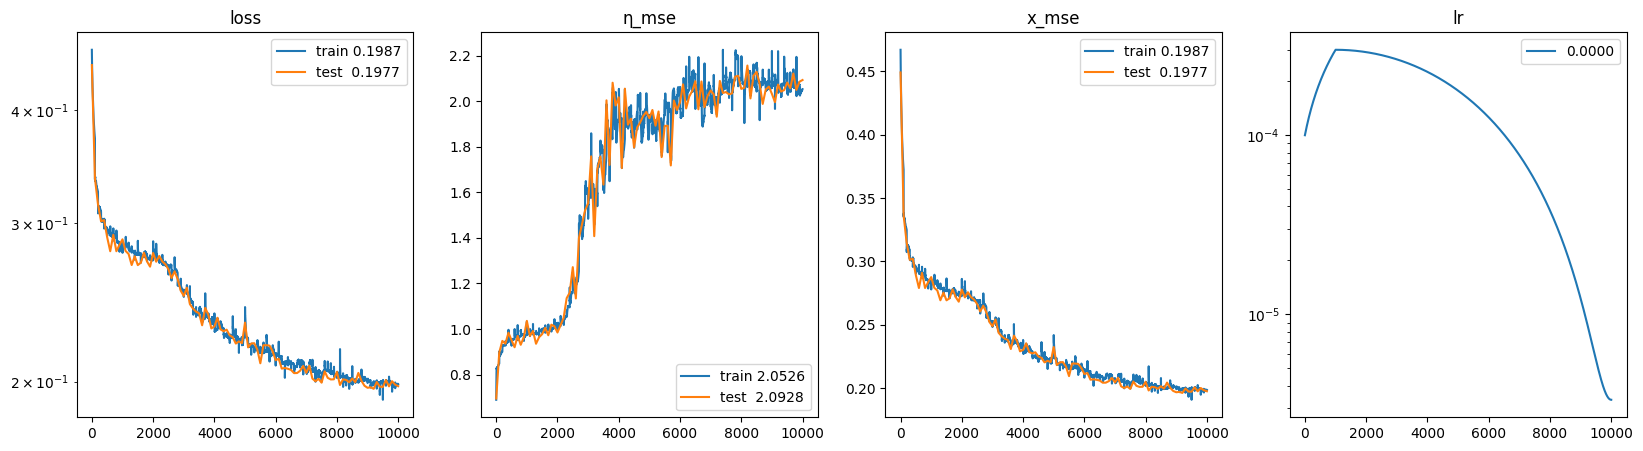

In [278]:
# plot the training history
steps, loss, η_mse, x_mse, λ, lr, grad_norm = ss_history.collect(
    "steps", "loss", "η_mse", "x_mse", "λ", "lr", "grad_norm"
)
steps_test, loss_test, η_mse_test, x_mse_test = ss_history.collect(
    "steps", "loss_test", "η_mse_test", "x_mse_test"
)

n_plots = 4
fig, axs = plt.subplots(1, n_plots, figsize=(5 * n_plots, 5))

axs[0].plot(steps, loss, label=f"train {loss[-1]:.4f}")
axs[0].plot(steps_test, loss_test, label=f"test  {loss_test[-1]:.4f}")
axs[0].legend()
axs[0].set_title("loss")
axs[0].set_yscale("log")

axs[1].plot(steps, η_mse, label=f"train {η_mse[-1]:.4f}")
axs[1].plot(steps_test, η_mse_test, label=f"test  {η_mse_test[-1]:.4f}")
axs[1].legend()
axs[1].set_title("η_mse")

axs[2].plot(steps, x_mse, label=f"train {x_mse[-1]:.4f}")
axs[2].plot(steps_test, x_mse_test, label=f"test  {x_mse_test[-1]:.4f}")
axs[2].legend()
axs[2].set_title("x_mse")

axs[3].plot(steps, lr, label=f"{lr[-1]:.4f}")
axs[3].legend()
axs[3].set_title("lr")
axs[3].set_yscale("log")

# axs[4].plot(steps, grad_norm, label=f"{grad_norm[-1]:.4f}")
# axs[4].legend()
# axs[4].set_title("grad_norm")

# axs[4].plot(steps, λ, label=f"{λ[-1]:.4f}")
# axs[4].legend()
# axs[4].set_title("λ")

plt.show()

In [291]:
# load the best model using flax checkpointing
import orbax
from flax.training import checkpoints

# orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
# best_ss_state = orbax_checkpointer.restore("ss_model", item=ss_state)
# best_ss_state

best_ss_state = checkpoints.restore_checkpoint(ckpt_dir='ss_model', target=ss_state)
best_ss_state.step

INFO:absl:Restoring orbax checkpoint from ss_model/checkpoint_-0.19632871448993683
INFO:absl:Restoring item from ss_model/checkpoint_-0.19632871448993683.
INFO:absl:Finished restoring checkpoint from ss_model/checkpoint_-0.19632871448993683.


Array(9201, dtype=int32)

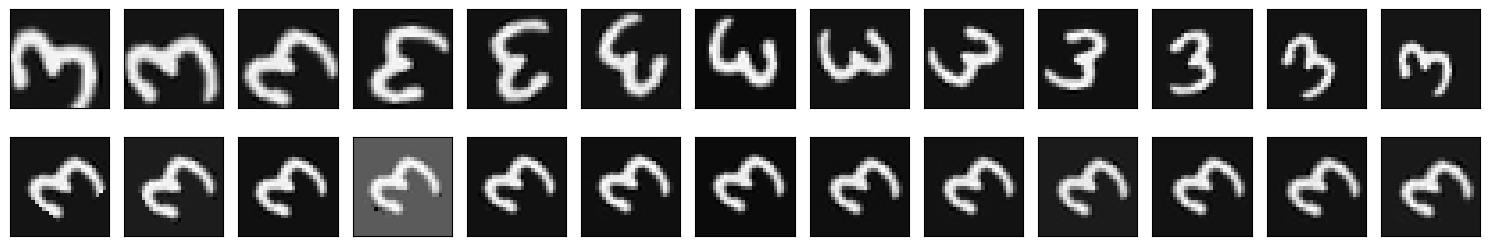

In [289]:
val_iter = deterministic_data.start_input_pipeline(val_ds)
val_batch = next(val_iter)

x_ = val_batch['image'][0][14]

def get_proto(x):
    η = best_ss_state.apply_fn({"params": best_ss_state.avg_params if best_ss_state.avg_params is not None else best_ss_state.params}, x, train=False)
    xhat = transform_image(x, -η)
    return xhat, η

for mask in [
    # jnp.array([0, 0, 1, 0, 0]),
    # jnp.array([1, 1, 0, 0, 0]),
    # jnp.array([0, 0, 0, 1, 1]),
    jnp.array([1, 1, 1, 1, 1])
]:

    transformed_xs = jax.vmap(transform_image, in_axes=(None, 0))(x_, jnp.linspace(-BOUNDS_ARRAY * mask, BOUNDS_ARRAY * mask, 13))

    xhats, ηs = jax.vmap(get_proto)(transformed_xs)

    fig, axs = plt.subplots(2, len(xhats), figsize=(15, 3))

    for ax, x in zip(axs[0], list(transformed_xs)):
        ax.imshow(x, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    for ax, xhat in zip(axs[1], list(xhats)):
        ax.imshow(xhat, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

[]

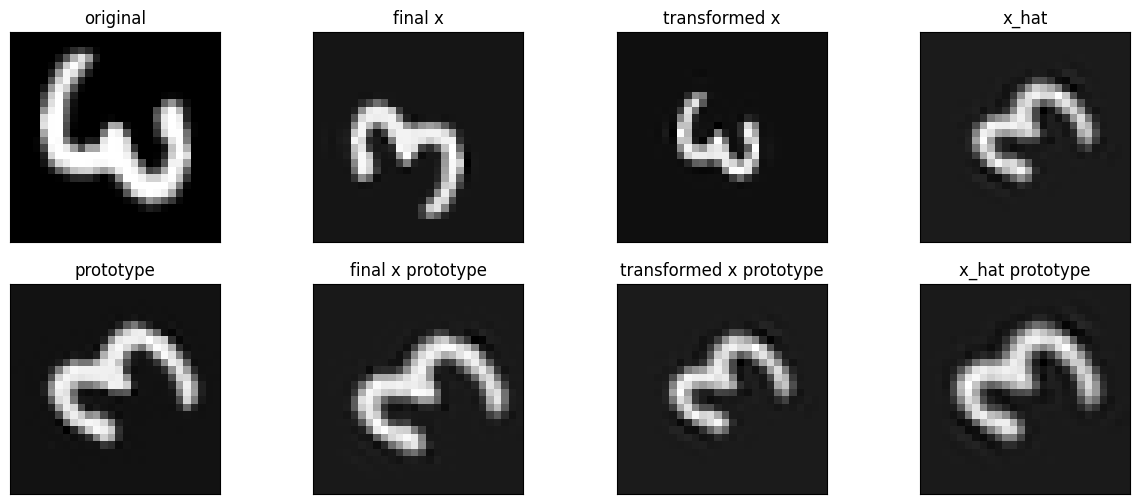

In [281]:
# make a figure with 2 rows and 4 columns
fig, axs = plt.subplots(2, 4, figsize=(15, 6))

# plot the original image
axs[0, 0].imshow(x_, cmap='gray')
axs[0, 0].set_title("original")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(x_)
axs[1, 0].imshow(xhat, cmap='gray')
axs[1, 0].set_title("prototype")
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

# plot x
axs[0, 1].imshow(x, cmap='gray')
axs[0, 1].set_title("final x")
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(x)
axs[1, 1].imshow(xhat, cmap='gray')
axs[1, 1].set_title("final x prototype")
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])

# transform again and plot the result
xx = transform_image(x, BOUNDS_ARRAY)
axs[0, 2].imshow(xx, cmap='gray')
axs[0, 2].set_title("transformed x")
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(xx)
axs[1, 2].imshow(xhat, cmap='gray')
axs[1, 2].set_title("transformed x prototype")
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])

# use that xhat as x
axs[0, 3].imshow(xhat, cmap='gray')
axs[0, 3].set_title("x_hat")
axs[0, 3].set_xticks([])
axs[0, 3].set_yticks([])

# plot the corresponding prototype
xhat, η = get_proto(xhat)
axs[1, 3].imshow(xhat, cmap='gray')
axs[1, 3].set_title("x_hat prototype")
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])


## Resampling code

In [282]:
def weighted_uniform_sampling(key, num_samples, bounds, weight_fn, temperature=1., mask=None):
    # Generate a fixed number of uniform samples
    samples = distrax.Uniform(low=-bounds, high=bounds).sample(seed=key, sample_shape=(num_samples*1000,))
    # Compute the weights based on the distance from the extreme values
    weights = weight_fn(samples, bounds, mask)
    # Apply the temperature to the weights
    weights = jnp.power(weights, 1.0 / temperature)
    # Normalize the weights
    weights /= jnp.sum(weights)
    # Resample the samples with the computed weights
    resampled_samples = distrax.Categorical(probs=weights).sample(seed=key, sample_shape=(num_samples,))
    return jnp.take(samples, resampled_samples, axis=0)

def weight_fn(samples, bounds, mask=None):
    if mask is None:
        mask = jnp.ones_like(bounds)
    mask = jnp.array(mask, dtype=bool)
    # Compute the distance of each sample from the extreme values
    distance = jnp.minimum(jnp.abs(samples - bounds), jnp.abs(samples + bounds))
    # Compute the weights based on the distance
    weights = jnp.where(mask, 1 - distance / bounds, 1).prod(axis=-1)
    return weights

samples = weighted_uniform_sampling(rng, 10, BOUNDS_ARRAY, weight_fn)
samples

Array([[ 0.2136234 ,  0.2329452 ,  1.6852534 ,  0.05451798, -0.20962691],
       [ 0.23280007,  0.21372545,  1.783849  ,  0.1709131 , -0.07764941],
       [-0.23876315, -0.2367773 , -2.7024615 ,  0.20791638, -0.2083779 ],
       [-0.01652765,  0.08712256,  2.989548  , -0.19389427, -0.21614218],
       [-0.23865324, -0.14975685,  2.5481012 ,  0.20497328, -0.20648342],
       [-0.19226778,  0.13995004, -1.2606333 , -0.2199406 , -0.19006175],
       [ 0.17519581,  0.05997324, -1.3852117 ,  0.14805722,  0.15768427],
       [-0.13811475, -0.19542664,  1.2930582 ,  0.2082532 , -0.1118598 ],
       [ 0.19016153,  0.00860667,  2.873442  ,  0.1323883 ,  0.247293  ],
       [ 0.24001324,  0.21788532, -2.650982  , -0.19398361, -0.20169932]],      dtype=float32)

In [283]:
jnp.abs(distrax.Uniform(low=-BOUNDS_ARRAY, high=BOUNDS_ARRAY).sample(seed=rng, sample_shape=(10*1000,))).mean()

Array(0.41388988, dtype=float32)

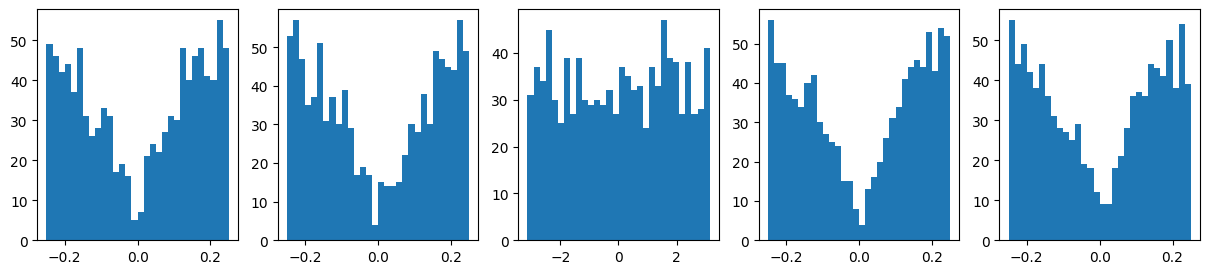

In [284]:
# make a distogram for each dimension
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

samples = weighted_uniform_sampling(rng, 1000, BOUNDS_ARRAY, weight_fn, 2., jnp.array([1, 1, 0, 1, 1]))

for i, ax in enumerate(axs):
    ax.hist(samples[:, i], bins=30)

plt.show()